In [620]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import sklearn.metrics as skm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [622]:
df=pd.read_excel("Euro2020new.xlsx")
Match_data=pd.read_excel('Match_data.xlsx')

In [ ]:
##creating function that will calculate result of game
def result(cols):
    homescore=cols[0]
    awayscore=cols[1]
    
    if homescore>awayscore:
        return 'win'
    elif homescore<awayscore:
        return 'loss'
    elif homescore==awayscore:
        return'draw'

In [ ]:
def result1(cols):
    outcome=cols
    
    
    if outcome=='win':
        return '1'
    elif outcome=='loss':
        return '2'
    elif outcome=='draw':
        return '0'

In [16]:
for i in range(len(df)):# calculating goals for/against, Wins/losses in previous year
    if df['Year'].iloc[i]>=2008:
        team=df['Team'].iloc[i]
        year=df['Year'].iloc[i]
      
        goalsf=df['Goals For'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['Goals For']
        goalsa=df['Goals Against'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['Goals Against']
        Wins=df['W'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['W']
        Losses=df['L'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['L']
        if not df[(df['Team']==team) & (df['Year']==year-1)]['Team'].empty:
            df.loc[i,'1_Year_change-goals']=goalsf.values
            df.loc[i,'1_Year_change-goalsa']=goalsa.values
            df.loc[i,'1_Year_change-W']=Wins.values
            df.loc[i,'1_Year_change-L']=Losses.values

In [10]:
df['Win/loss ratio']=df[['1_Year_change-W','1_Year_change-L']].apply(lambda x: x['1_Year_change-W']/(x['1_Year_change-W']+x['1_Year_change-L']),axis=1)

C:\Users\mkepa\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [22]:
df['Goals Difference']=df[['1_Year_change-goals','1_Year_change-goalsa']].apply(lambda x: x['1_Year_change-goals']-x['1_Year_change-goalsa'],axis=1)

In [27]:
df.drop(df[df.Year==2007].index,inplace=True)

In [30]:
df.reset_index(drop=True, inplace=True)

In [16]:
##changing Country names to match ELO rating file
Match_data['Home_Team']=Match_data['Home_Team'].replace(['Czech Republic','North. Ireland','Rep. of Ireland','Bosnia & Herzegovina','U.A.E.','C?te d`Ivoire','Trinidad & Tobago'],
                                ['Czechia','Northern Ireland','Ireland','Bosnia and Herzegovina','United Arab Emirates','Ivory Coast','Trinidad and Tobago'])

Match_data['Away_Team']=Match_data['Away_Team'].replace(['Czech Republic','North. Ireland','Rep. of Ireland','Bosnia & Herzegovina','U.A.E.','C?te d`Ivoire','Trinidad & Tobago','Romana','Rep. Of Ireland'],
                                ['Czechia','Northern Ireland','Ireland','Bosnia and Herzegovina','United Arab Emirates','Ivory Coast','Trinidad and Tobago','Romania','Ireland'])

In [49]:
Match_data['Date']=pd.to_datetime(Match_data['Date'])## adding column with year
Match_data['Year']=Match_data['Date'].apply(lambda time: time.year)

In [51]:
Match_data.drop('Date',inplace=True,axis=1)

In [85]:
for i in range(len(Match_data)):## Adding ELO rating,1_Year_change-goals,1_Year_change-goalsa,Goals Difference,Win/loss ratio to match data
    home=Match_data['Home_Team'].iloc[i]
    away=Match_data['Away_Team'].iloc[i]
    year=Match_data['Year'].iloc[i]
    
    homeR=df[(df['Team']==home) & (df['Year']==year)]['R']
    awayR=df[(df['Team']==away) & (df['Year']==year)]['R']
    homeg=df[(df['Team']==home) & (df['Year']==year)]['1_Year_change-goals']
    awayg=df[(df['Team']==away) & (df['Year']==year)]['1_Year_change-goals']
    homelg=df[(df['Team']==home) & (df['Year']==year)]['1_Year_change-goalsa']
    awaylg=df[(df['Team']==away) & (df['Year']==year)]['1_Year_change-goalsa']
    goalsdiffhome=df[(df['Team']==home) & (df['Year']==year)]['Goals Difference']
    goalsdiffaway=df[(df['Team']==away) & (df['Year']==year)]['Goals Difference']
    winlosth=df[(df['Team']==home) & (df['Year']==year)]['Win/loss ratio']
    winlosta=df[(df['Team']==away) & (df['Year']==year)]['Win/loss ratio']

    
    Match_data.loc[i,'Home_Elo rating']=homeR.values
    Match_data.loc[i,'Away_Elo rating']=awayR.values
    Match_data.loc[i,'1_Year_change-goals-home']=homeg.values
    Match_data.loc[i,'1_Year_change-goals-away']=awayg.values
    Match_data.loc[i,'1_Year_change-lost_goals-home']=homelg.values
    Match_data.loc[i,'1_Year_change-lost_goals-away']=awaylg.values
    Match_data.loc[i,'Goals_diff_home']=goalsdiffhome.values
    Match_data.loc[i,'Goals_diff_away']=goalsdiffaway.values
    Match_data.loc[i,'Win/loss ratio-home_team']=winlosth.values
    Match_data.loc[i,'Win/loss ratio-away_team']=winlosta.values
   

In [32]:
gdp=pd.read_excel('GDP.xlsx')

In [88]:
for i in range(len(Match_data)):## Adding GDP  to match data
    
    home=Match_data['Home_Team'].iloc[i]
    away=Match_data['Away_Team'].iloc[i]
    year=str(Match_data['Year'].iloc[i])
    homeGDP=gdp[gdp['Country Name']==home][year]
    awayGDP=gdp[gdp['Country Name']==away][year]
    if not gdp[gdp['Country Name']==home][year].empty:
        Match_data.loc[i,'Home_GDP']=homeGDP.values
       
    if not gdp[gdp['Country Name']==away][year].empty:
        Match_data.loc[i,'Away_GDP']=awayGDP.values
        
    

In [4]:
Match_data['Home_GDP'].isna().sum()/Match_data.shape[0]*100 ##percantege of nill values in Home GDP

4.39297124600639

In [17]:
Match_data['Home_GDP']=Match_data['Home_GDP'].fillna(Match_data['Home_GDP'].mean())##filling nill GDP with mean
Match_data['Away_GDP']=Match_data['Away_GDP'].fillna(Match_data['Away_GDP'].mean())

In [6]:
Match_data['Home_GDP'].isna().sum()

0

In [55]:
##adding win/loss/draw based on result
Match_data['Result']=Match_data[['Home_score','Away_Score']].apply(result,axis=1)

In [591]:
###adding 1-win team A,0-draw,2-win team B 
Match_data['Y']=Match_data['Result'].apply(result1)


In [642]:

### Creating Exogenous variables data frame#
X=Match_data[['FIFA_Points_Home','FIFA_Points_Away','Home_Elo rating','Away_Elo rating','1_Year_change-wins_home','1_Year_change-wins_away','1_Year_change-loss_home','1_Year_change-loss_away','1_Year_change-goals-home','1_Year_change-goals-away','1_Year_change-lost_goals-home','1_Year_change-lost_goals-away']]

In [643]:
##Creating endogenous variable

y=Match_data['Y']


In [644]:
## Normalizing FIFA and ELO rating points
X_to_normalize=X[['FIFA_Points_Home','FIFA_Points_Away','Home_Elo rating','Away_Elo rating']]
X_without_normalize=X[['1_Year_change-wins_home','1_Year_change-wins_away','1_Year_change-loss_home','1_Year_change-loss_away','1_Year_change-goals-home','1_Year_change-goals-away','1_Year_change-lost_goals-home','1_Year_change-lost_goals-away']]
scale=MinMaxScaler()
X_norm=pd.DataFrame(scale.fit_transform(X_to_normalize),

columns=X_to_normalize.columns, index=X_to_normalize.index)

X=pd.concat([X_norm,X_without_normalize],axis=1)

In [466]:
## creating model to check which variables are irrelevant
model = sm.Logit(y, X)

In [467]:
result = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.528473
         Iterations 6


In [468]:
result.params

FIFA_Points_Home                 1.495066
FIFA_Points_Away                -1.801165
Home_Elo rating                  4.561689
Away_Elo rating                 -5.308379
1_Year_change-wins_home         -0.511012
1_Year_change-wins_away          2.061539
1_Year_change-loss_home          0.738626
1_Year_change-loss_away         -0.394149
1_Year_change-goals-home         0.542848
1_Year_change-goals-away        -1.594626
1_Year_change-lost_goals-home   -0.798526
1_Year_change-lost_goals-away    0.917891
dtype: float64

In [469]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Result4   No. Observations:                 2496
Model:                          Logit   Df Residuals:                     2484
Method:                           MLE   Df Model:                           11
Date:                Thu, 10 Jun 2021   Pseudo R-squ.:                  0.2300
Time:                        00:16:08   Log-Likelihood:                -1319.1
converged:                       True   LL-Null:                       -1713.0
Covariance Type:            nonrobust   LLR p-value:                7.817e-162
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
FIFA_Points_Home                  1.4951      0.363      4.122      0.000       0.784       2.206
FIFA_Points_Away                 -1.8012      0.363     -4.960      0.000      -2.513      -1.089
Home_Elo rating                   4.5617      0.518      8.815      0.000       3.547       5.576
Away_Elo rating                  -5.3084      0.529    -10.032      0.000      -6.345      -4.271
1_Year_change-wins_home          -0.5110      0.628     -0.813      0.416      -1.742       0.720
1_Year_change-wins_away           2.0615      0.670      3.075      0.002       0.747       3.376
1_Year_change-loss_home           0.7386      0.517      1.429      0.153      -0.275       1.752
1_Year_change-loss_away          -0.3941      0.491     -0.802      0.423      -1.357       0.569
1_Year_change-goals-home          0.5428      0.713      0.761      0.447      -0.855       1.941
1_Year_change-goals-away         -1.5946      0.765     -2.084      0.037      -3.094      -0.095
1_Year_change-lost_goals-home    -0.7985      0.670     -1.192      0.233      -2.112       0.515
1_Year_change-lost_goals-away     0.9179      0.695      1.320      0.187      -0.445       2.280
=================================================================================================
"""

In [626]:
## creating function that evaluates optimal l2 penalty value
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        # create name for model
        key = '%.4f' % p
        # turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
    return models

In [627]:
models = get_models()
results, names = list(), list()

def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>0.0000 0.591 (0.023)
>0.0001 0.545 (0.027)
>0.0010 0.547 (0.028)
>0.0100 0.559 (0.029)
>0.1000 0.585 (0.019)
>1.0000 0.589 (0.022)


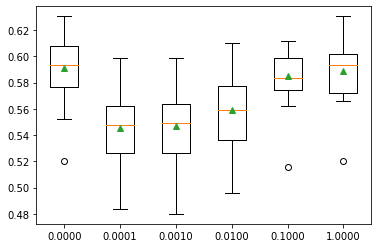

In [628]:
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [676]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
model=LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none',max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [677]:
predictions=model.predict(X_test)

In [678]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.03      0.06       163
           1       0.63      0.82      0.71       325
           2       0.61      0.74      0.67       261

    accuracy                           0.62       749
   macro avg       0.69      0.53      0.48       749
weighted avg       0.67      0.62      0.55       749



In [679]:
confusion_matrix(y_test,predictions)## rows are actual values, columns predicted

array([[  5,  90,  68],
       [  1, 267,  57],
       [  0,  68, 193]], dtype=int64)

In [680]:
y_test.value_counts()

1    325
2    261
0    163
Name: Y, dtype: int64

In [681]:
model.score(X_train,y_train)

0.5809959931310819

In [682]:
lr_probs=model.predict_proba(X_test)

In [683]:
lr_probs0 = lr_probs[:,0]
lr_probs1=lr_probs[:,1]
lr_probs2=lr_probs[:,2]

In [684]:
precision0, recall0, _ = skm.precision_recall_curve(y_test,lr_probs0,pos_label=0)
precision1, recall1, _ = skm.precision_recall_curve(y_test,lr_probs1,pos_label=1)
precision2, recall2, _ = skm.precision_recall_curve(y_test,lr_probs2,pos_label=2)

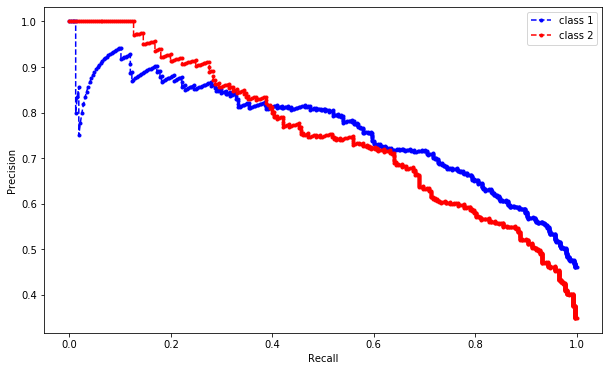

In [685]:
plt.figure(figsize=(10,6))
plt.plot(recall1, precision1,'b', label='class 1',linestyle='--',marker='.')
plt.plot(recall2, precision2,'r', label='class 2',linestyle='--',marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

In [686]:
lr_auc1=auc(recall1, precision1)
lr_auc2=auc(recall2, precision2)

In [687]:
print(lr_auc1,lr_auc2)


0.7612392243803298 0.7510054575547354


In [688]:
## predicting Euro 2020 games results
data_to_predict1=pd.read_excel("data_to_predict1.xlsx")

In [689]:
predict_data_normalize=data_to_predict1[['FIFA_Points_Home','FIFA_Points_Away','Home_Elo rating','Away_Elo rating']]
predict_data_without_normalize=data_to_predict1[['1_Year_change-wins_home','1_Year_change-wins_away','1_Year_change-loss_home','1_Year_change-loss_away','1_Year_change-goals-home','1_Year_change-goals-away','1_Year_change-lost_goals-home','1_Year_change-lost_goals-away']]

In [690]:
X_norm=pd.DataFrame(scale.fit_transform(predict_data_normalize),

columns=predict_data_normalize.columns, index=predict_data_normalize.index)

In [691]:
X_to_predict=pd.concat([X_norm,predict_data_without_normalize],axis=1)

In [692]:
X_to_predict.head()

,FIFA_Points_Home,FIFA_Points_Away,Home_Elo rating,Away_Elo rating,1_Year_change-wins_home,1_Year_change-wins_away,1_Year_change-loss_home,1_Year_change-loss_away,1_Year_change-goals-home,1_Year_change-goals-away,1_Year_change-lost_goals-home,1_Year_change-lost_goals-away
0,0.320293,0.655257,0.339483,0.791513,1,5,2,0,12,17,14,2
1,0.479218,0.567237,0.479705,0.557196,5,0,1,4,7,8,4,12
2,0.628362,0.088020,0.660517,0.258303,5,5,2,3,14,10,7,10
3,1.000000,0.215159,1.000000,0.321033,6,2,1,3,19,10,8,14
4,0.762836,0.564792,0.725092,0.536900,5,2,2,5,13,14,4,20


In [694]:
predictions=model.predict_proba(X_to_predict)

In [698]:
Euro_predictions=pd.DataFrame(data=predictions, columns=['draw','Team1-win%','Team2-win%']).round(decimals=2)

In [709]:
Euro_predictions=Euro_predictions.apply(lambda x : x*100,axis=1)

In [711]:
Euro_predictions.to_excel('Euro_predictions.xlsx')